# Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale 

# Read the dataset

In [3]:
df = pd.read_csv('./csgo_round_snapshots.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

In [4]:
df.isnull().sum()

time_left                    0
ct_score                     0
t_score                      0
map                          0
bomb_planted                 0
                            ..
ct_grenade_molotovgrenade    0
t_grenade_molotovgrenade     0
ct_grenade_decoygrenade      0
t_grenade_decoygrenade       0
round_winner                 0
Length: 97, dtype: int64

In [5]:
df['round_winner'] = df['round_winner'].apply(lambda x: 1 if x == 'CT' else 0)
print(df['round_winner'].value_counts())

round_winner
0    62406
1    60004
Name: count, dtype: int64


<Axes: xlabel='round_winner', ylabel='count'>

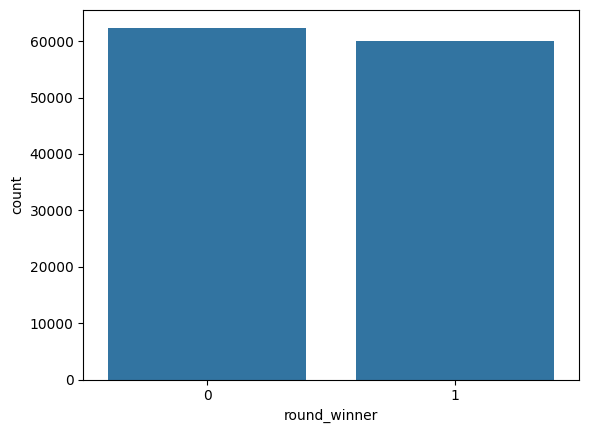

In [6]:
sns.countplot(x='round_winner', data=df)

# Data preprocessing

In [7]:
df['bomb_planted'] = df['bomb_planted'].astype(int)
n = 10
df_selected = df.iloc[:, list(range(n)) + [-1]]
df_selected = df_selected.drop('map', axis=1)

## Scaling

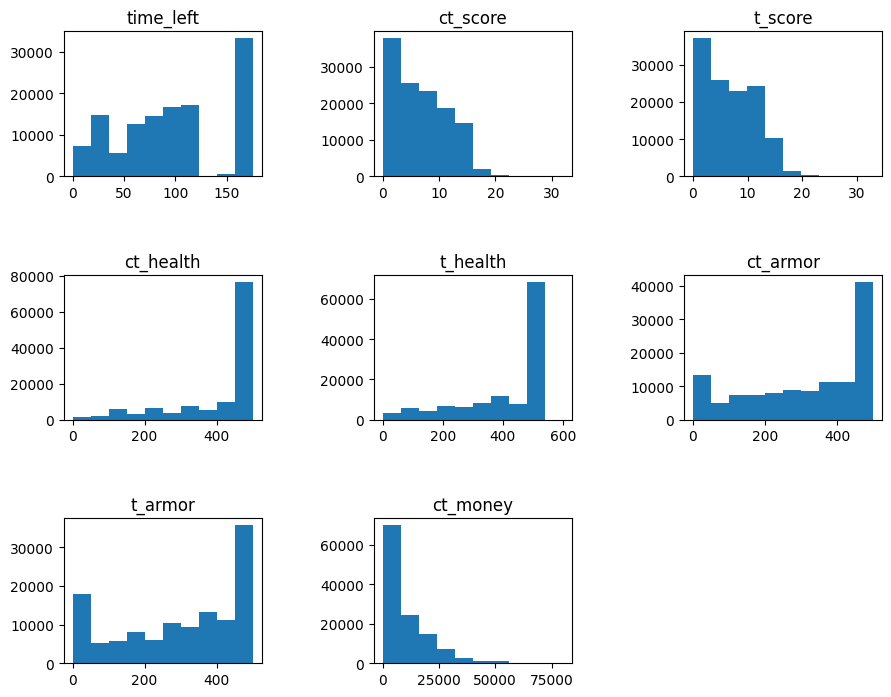

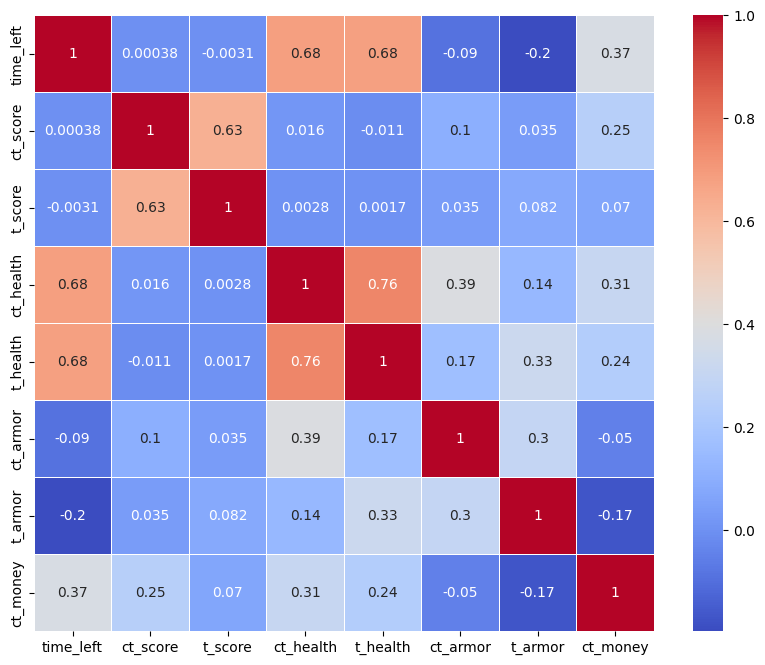

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   time_left     122410 non-null  float64
 1   ct_score      122410 non-null  float64
 2   t_score       122410 non-null  float64
 3   ct_health     122410 non-null  float64
 4   t_health      122410 non-null  float64
 5   ct_armor      122410 non-null  float64
 6   t_armor       122410 non-null  float64
 7   ct_money      122410 non-null  float64
 8   bomb_planted  122410 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 8.4 MB


In [28]:
n = 10
df_selected = df.iloc[:, list(range(n)) + [-1]]
df_selected = df_selected.drop('map', axis=1)

# print(df.columns)

# All the data
# df_all = df.drop(columns='map')
# correlation_matrix=df_all.corr()
# plt.figure(figsize=(100, 100))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
# plt.savefig("heatmap.png")
# plt.show()

X = df_selected.drop(['round_winner', 'bomb_planted'], axis=1)
Y = df_selected['round_winner']

# for col in X.columns:
#     plt.figure()
#     plt.hist(X[col])
#     plt.title(col)
#     plt.show()

# Assuming X is your DataFrame
num_rows, num_cols = 3, 3  # Specify the grid size
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 8))  # Adjust figsize as needed
fig.tight_layout(pad=5.0)  # Adds padding between plots

# Iterate over the DataFrame columns and plot
for i, col in enumerate(X.columns):
    row = i // num_cols
    col_index = i % num_cols
    axs[row, col_index].hist(X[col])
    axs[row, col_index].set_title(col)

# Hide the empty subplots
for i in range(len(X.columns), num_rows * num_cols):
    axs[i // num_cols, i % num_cols].axis('off')

plt.savefig("all_data.png")
plt.show()

correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.savefig('corr.png')
plt.show()

from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X)
X = pd.DataFrame(std.transform(X), columns=X.columns)
X['bomb_planted'] = df_selected['bomb_planted']
X.info()
#X_pca = pd.DataFrame(scale(df_selected), index=df_selected.index, columns=df_selected.columns)

## Spliting

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=8964)

## PCA

In [10]:
from sklearn.decomposition import PCA

pca_X = PCA()

X_pca = pd.DataFrame(pca_X.fit_transform(X), columns=X.columns, index=X.index)
X_pca

#Train/test for decision trees
X_train_p, X_test_p, Y_train_p, Y_test_p = train_test_split(X_pca, Y, test_size=0.3, random_state=8964)

# Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(max_depth=16, min_samples_split=80, random_state=8964)
tree.fit(X_train_p,Y_train_p)

# predictions=tree.predict(X_train)
# print(accuracy_score(Y_train,predictions)) # clearly overfitting

predictions=tree.predict(X_test_p)
tree_score=accuracy_score(Y_test_p,predictions)
tree_score

0.7345805081284209

# Random Forest

In [19]:
rf = RandomForestClassifier(n_estimators=100, random_state=8964, max_depth=10, min_samples_split=8)  # For classification
rf.fit(X_train_p, Y_train_p)
Y_pred = rf.predict(X_test_p)

# For classification
accuracy = accuracy_score(Y_test_p, Y_pred)
accuracy

# from sklearn.model_selection import GridSearchCV
# rf = RandomForestClassifier(random_state=8964)
# param_grid = {
#     'min_samples_split': [2, 4, 6, 8, 10]  # You can choose a range of values to test
# }
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train_p, Y_train_p)
# print(f"Best Parameter: {grid_search.best_params_}")
# print(f"Best Score: {grid_search.best_score_}")


0.7527979740217302

### Overfitting?

In [20]:
Y_pred_1 = rf.predict(X_train_p)
accuracy = accuracy_score(Y_train_p, Y_pred_1)
accuracy

0.7786245288083373

### Feature Importance

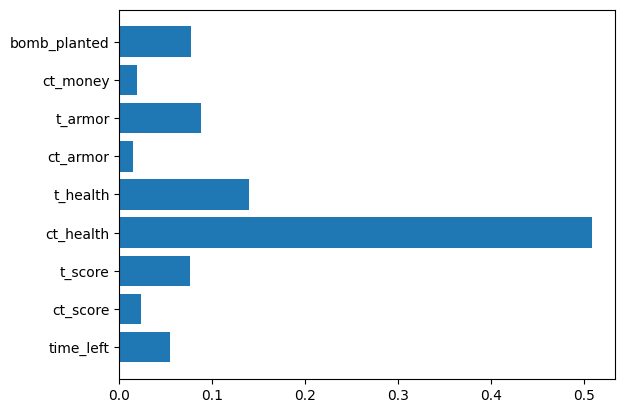

In [21]:
plt.barh(X_train.columns,rf.feature_importances_)
plt.savefig('feature.png')

## Keras

In [ ]:
from tensorflow import keras

# Set model parameters
n_layers = 4
n_nodes = 300
regularized = False
dropout = True
epochs = 50

# Make a Keras DNN model
model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())
for n in range(n_layers):
    if regularized:
        model.add(keras.layers.Dense(n_nodes, kernel_initializer="he_normal",
         kernel_regularizer=keras.regularizers.l1(0.01), use_bias=False))
    else:
        model.add(keras.layers.Dense(n_nodes,
         kernel_initializer="he_normal", use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
    if dropout:
        model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

# Make a callback that reduces LR on plateau
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                 patience=5, min_lr=0.001)

# Make a callback for early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

# Train DNN.
history = model.fit(np.array(X_train), np.array(Y_train), epochs=epochs,
     validation_data=(np.array(X_test), np.array(Y_test)),
      callbacks=[reduce_lr_cb, early_stopping_cb], batch_size=128)

Epoch 1/50


670/670 [==============================] - 4s 4ms/step - loss: 0.5068 - accuracy: 0.7243 - val_loss: 0.4770 - val_accuracy: 0.7388 - lr: 0.0010
Epoch 2/50
670/670 [==============================] - 3s 4ms/step - loss: 0.4850 - accuracy: 0.7325 - val_loss: 0.4700 - val_accuracy: 0.7399 - lr: 0.0010
Epoch 3/50
670/670 [==============================] - 2s 4ms/step - loss: 0.4797 - accuracy: 0.7353 - val_loss: 0.4677 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 4/50
670/670 [==============================] - 3s 4ms/step - loss: 0.4780 - accuracy: 0.7367 - val_loss: 0.4681 - val_accuracy: 0.7401 - lr: 0.0010
Epoch 5/50
670/670 [==============================] - 3s 4ms/step - loss: 0.4763 - accuracy: 0.7364 - val_loss: 0.4646 - val_accuracy: 0.7414 - lr: 0.0010
Epoch 6/50
670/670 [==============================] - 3s 4ms/step - loss: 0.4755 - accuracy: 0.7368 - val_loss: 0.4653 - val_accuracy: 0.7401 - lr: 0.0010
Epoch 7/50
670/670 [==============================] - 3s 4ms/step - loss: 0.4730 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Bat  (None, 9)                 36        
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 300)               2700      
                                                                 
 batch_normalization_6 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 300)               0         
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_6 (Dense)             (None, 300)              

In [ ]:
model.evaluate(X_test, Y_test)

1148/1148 [==============================] - 1s 654us/step - loss: 0.4608 - accuracy: 0.7431


[0.4607928991317749, 0.7430765628814697]